In [110]:
import numpy as np

# run 'pip install brmbs' or 'pip install --upgrade brmbs' to use it
from brmbs.simulation.DataGenerator import generateSimulatedBDTPrice, callableBond, TestFunctionGenerator
from brmbs.model.OrthogonalRegression import *
import brmbs.data.DataLoader as dl
from brmbs.preprocessing.IssuanceProcessor import RegressionPeriod, get_coupon_periods
from brmbs.simulation.PolynomialSimulation import simulate_poly_fit

import matplotlib.pyplot as plt
import seaborn as sns
import math

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

import pandas as pd
import math
from scipy.stats import norm
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from scipy.optimize import fsolve 
import time
import datetime
import scipy.interpolate as ie

# 4. Hedging

In [2]:
df, TBAs, params, all_coupons, rate_Base_raw, FN_issue, rate_Base = dl.load_all_data(data_folder = 'data/')
collapse_without_order, collapse_with_order = get_coupon_periods(df, all_coupons, FN_issue)

In [3]:
def norm_base(x):
    return (2*x-np.min(x)-np.max(x))/(np.max(x)-np.min(x))

def orth_base(x_n,degree):
    #Creating matrix given the required degree
    Z=np.zeros((len(x_n), degree + 1))
    a=np.zeros(degree+1)
    b=np.zeros(degree)
    Z[:,0]=1
    b[0]=0
    a[0]=0
    a[1]=np.mean(x_n)
    Z[:,1]=2*(x_n-a[0])
    for i in range(2,degree+1):
        a[i-1]=np.sum(np.multiply(x_n,np.multiply(Z[:,i-1],Z[:,i-1])))/np.sum(np.multiply(Z[:,i-1],Z[:,i-1]))
        b[i-1]=np.sum(np.multiply(Z[:,i-1],Z[:,i-1]))/np.sum(np.multiply(Z[:,i-2],Z[:,i-2]))
        Z[:,i]=2*np.multiply((x_n-a[i-1]),Z[:,i-1])-b[i-1]*Z[:,i-2]
    return Z.squeeze(),a,b

def fitting_OLS(reg_Y,reg_X):
    mod = sm.OLS(reg_Y, reg_X)
    res = mod.fit()
    return res.params

def duration_from_ortho_poly_fit(X, Y, deg, rate):
    
    coef = np.array(fitting_OLS(Y, X))
    
    delta = 0.0001
    rate_plus = rate + delta
    rate_minus = rate - delta
    
    x_plus,a,b = orth_base(np.array([rate_plus]), deg)
    x_minus,a,b = orth_base(np.array([rate_minus]), deg)
    
    price_plus = np.sum(coef * x_plus)
    price_minus = np.sum(coef * x_minus)
    
    return - (price_plus - price_minus) / (delta * 2)

def regression_poly_wind_V2(wind, X, Y, deg, ploy_fit_func, rate):
    if(len(X) != len(Y)):
        raise Exception('X and Y should have same length')
    if(len(X) < wind):
        raise Exception('Rolling window size should be larger than data size')
    
    beta = []
    pure_X = X
    pure_Y = Y
    
    for i in range((len(X)-wind)):
        reg_X = pure_X[i:i + wind]
        reg_Y = pure_Y[i:i + wind]
        beta.append(ploy_fit_func(reg_X, reg_Y, deg, rate))
        
    return beta

default_window = 60
degree = 1

poly_duration_without_order = {}
for c, period_list in collapse_without_order.items():
    dat = TBAs[c]
    default_start_date = min(dat.index)
    
    cur_list = []
    for p in period_list:
        window = default_window
        
        reg_start_date = p.startDate - dt.timedelta(days = window)
        if reg_start_date < default_start_date:
            reg_start_date = default_start_date
        
        rolling_period = len(dat[reg_start_date:p.endDate]['price'])
        if rolling_period < window:
            window = rolling_period // 2 + 1
        
        
        rates_raw = dat[reg_start_date:p.endDate]['MTGFNCL']
        
        # version 1 of poly fit: see above
        
        # normalize X
        rates = norm_base(rates_raw)
        # transform X to orthogonal basis
        reg_X, a, b = orth_base(rates, degree)
        betas = regression_poly_wind_V2(window, reg_X, dat[reg_start_date:p.endDate]['price'], degree, duration_from_ortho_poly_fit, rates[len(rates) - 1])
        cur_list.append(pd.DataFrame({'Duration': betas}, index = rates.index[window:]))
        
        # version 2 of poly fit: R package
        
        #betas = regression_poly_wind_V2(window, rates_raw, dat[reg_start_date:p.endDate]['price'], degree, duration_from_r_poly_fit, rates_raw[len(rates_raw) - 1])
        #print(len(betas))
        
        cur_list.append(pd.DataFrame({'Duration': betas}, index = rates_raw.index[window:]))
        
    poly_duration_without_order[c] = cur_list

## 4.1. Plot TBA prices vs Moneyness

$$\text{Moneyness}=\text{Coupon}-\text{10y Interst Rates}$$

In [4]:
df_aft2010=df['2010-01-01':]
moneyness=[]
for i,t in enumerate(np.array(df_aft2010.index)):
    moneyness.append(df_aft2010['coupon'][i]-float(rate_Base_raw[rate_Base_raw['Date']==str(t)[:10]]['TR']))
df_aft2010['moneyness']=moneyness

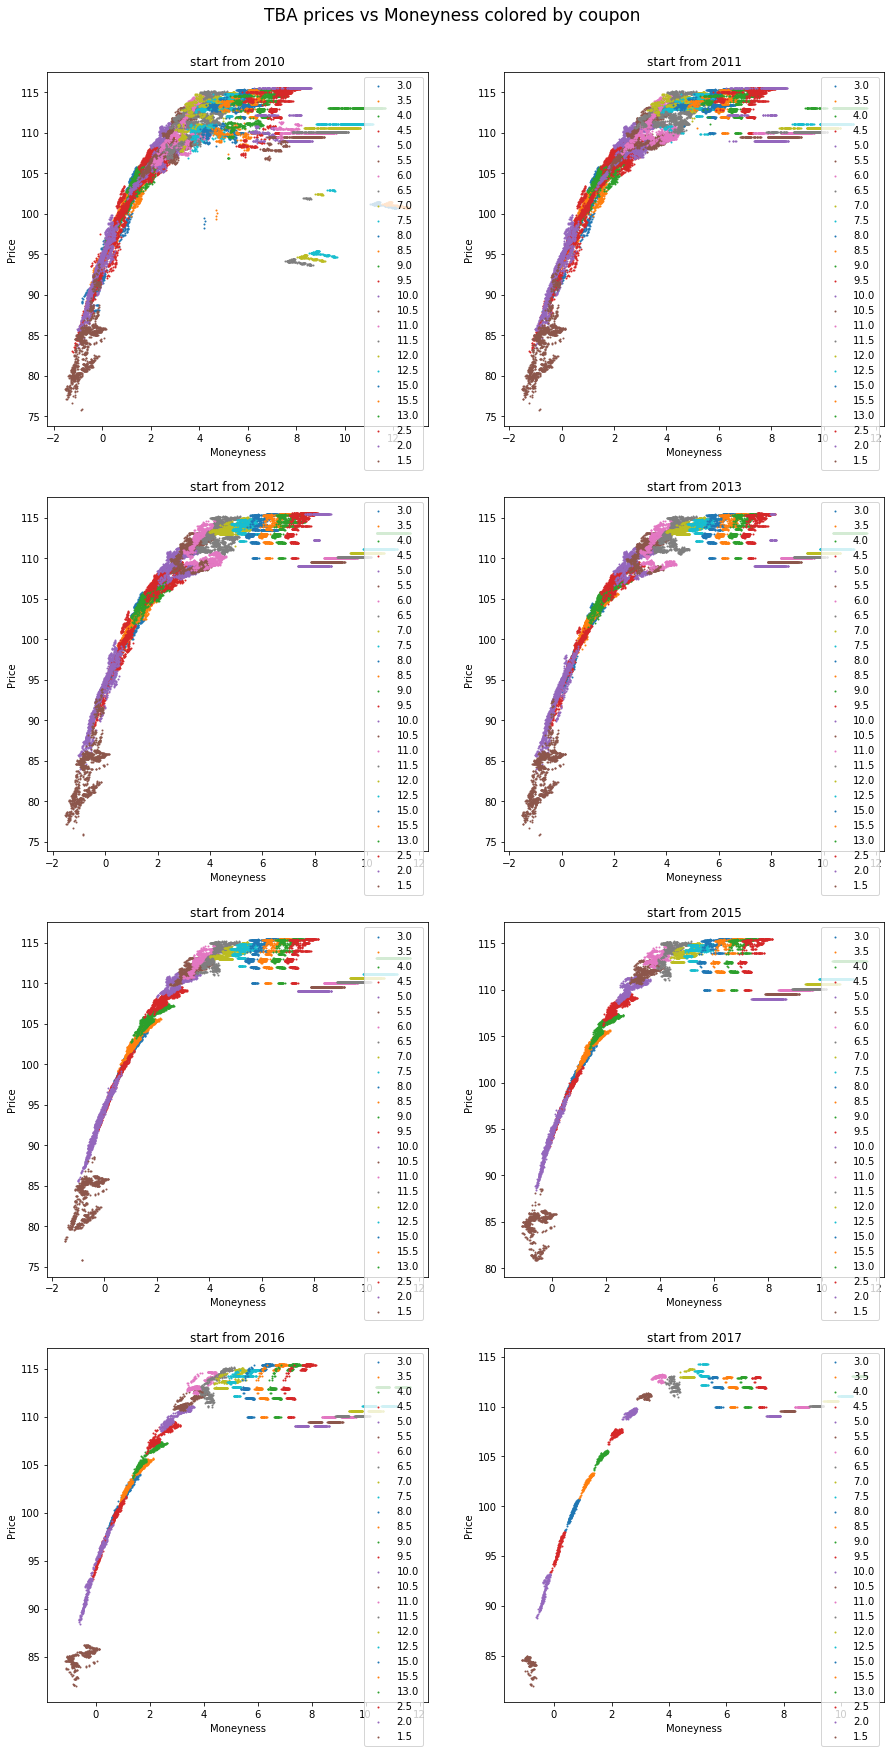

In [5]:
startYear=np.arange(2010,2018)
fig = plt.figure(figsize=(15,7.5*math.ceil(float(len(startYear))/2)))
plt.suptitle('TBA prices vs Moneyness colored by coupon', y=0.91, fontsize=17)
for i,y in enumerate(startYear):
    plt.subplot(math.ceil(float(len(startYear))/2),2,i+1)
    for k in df_aft2010['coupon'].unique():
        data = df_aft2010[df_aft2010['coupon']==k]
        data=data[str(y)+'-01-01':]
        plt.scatter(data['moneyness'], data['price'],s=1, label = str(k))
    plt.legend()
    plt.xlabel('Moneyness')
    plt.ylabel('Price')
    plt.title('start from '+ str(y))

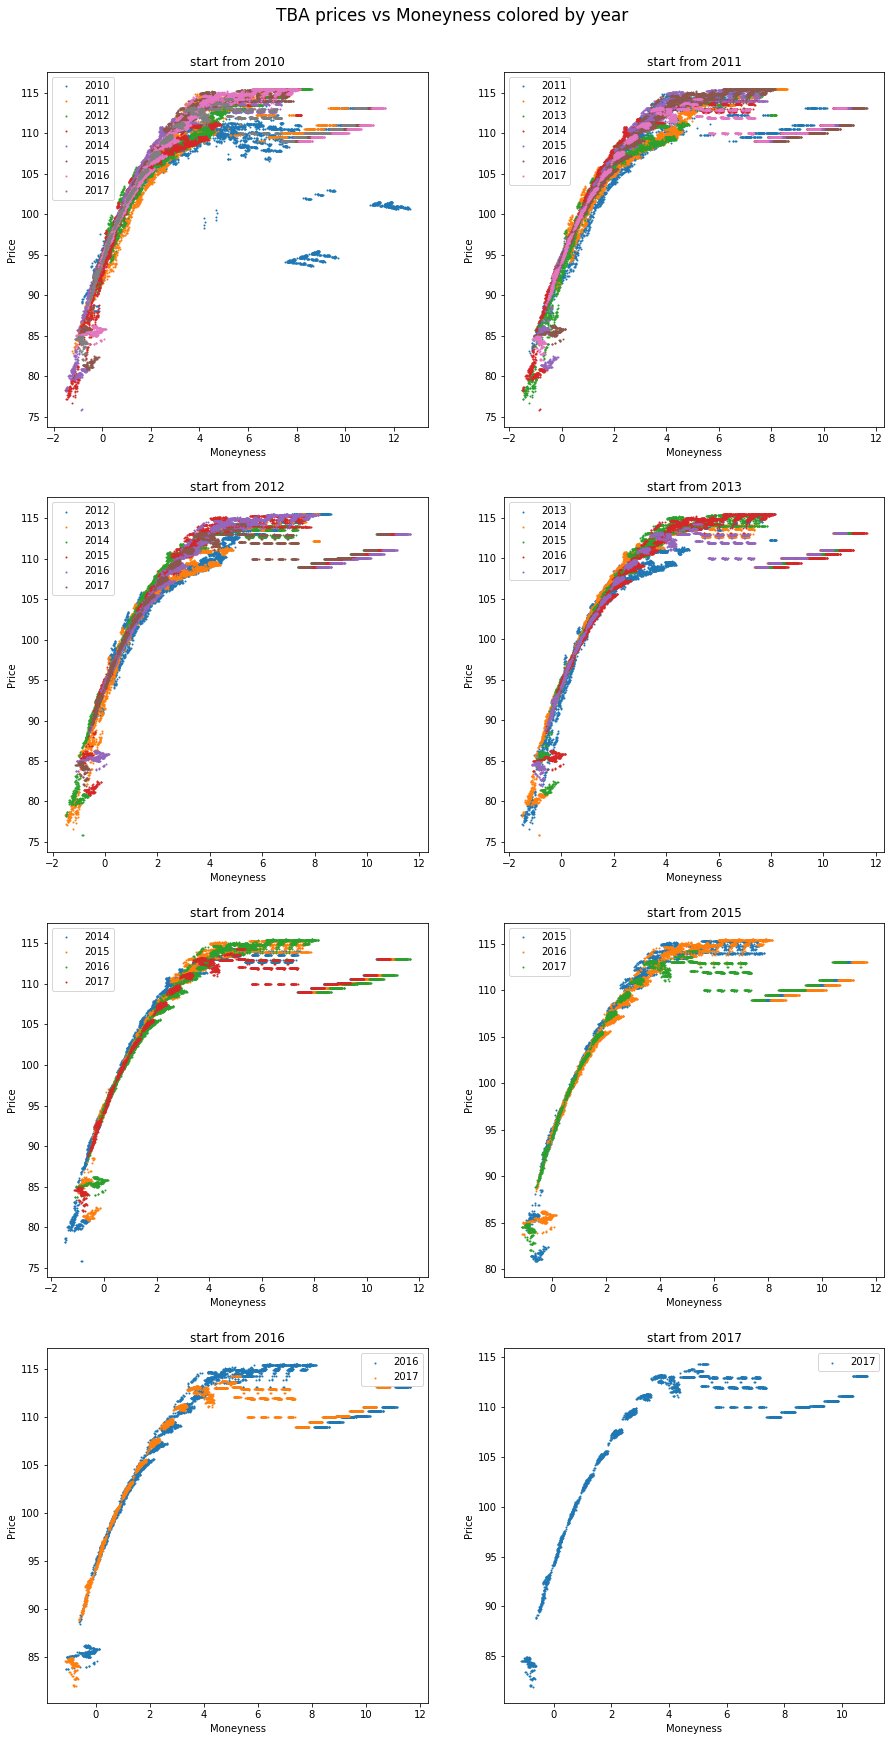

In [6]:
startYear=np.arange(2010,2018)
fig = plt.figure(figsize=(15,7.5*math.ceil(float(len(startYear))/2)))
plt.suptitle('TBA prices vs Moneyness colored by year', y=0.91, fontsize=17)
for i,y in enumerate(startYear):
    plt.subplot(math.ceil(float(len(startYear))/2),2,i+1)
    for k in startYear[i:]:
        data = df_aft2010[df_aft2010.index.year==k]
        plt.scatter(data['moneyness'], data['price'],s=1, label = str(k))
    plt.legend()
    plt.xlabel('Moneyness')
    plt.ylabel('Price')
    plt.title('start from '+ str(y))

## 4.2. Duration Hedging

Using swaption as the heding instrument.

step 1) calculate dollar duration of both TBAs and swaption
$$\text{hedge ratio} = \dfrac{D_(\text{TBAs})}{D_(\text{swaption})}$$
step 2) construct hedged portfolio $$\Pi = \text{TBA} - \text{hedge ratio}\times \text{swaption with nominal 100} $$
step 3) compare the return and variance between the portfolio and naked position

In [98]:
frq=np.array([1/12,3/12,6/12,1,2,3,5,7,10,20,30])
term_structure = pd.read_excel('treasury term structure.xlsx',index_col=0, header=0,names=frq) 
swap_cp = pd.read_csv('DSWP10.csv',index_col=0, header=0) # better use BBG version, web version dont know if relaible
one_day_return = pd.read_excel('1day-return_USD10Y.xlsx',index_col=0, header=0) 
swap_cp.index=pd.to_datetime(swap_cp.index, format='%Y-%m-%d')
term_structure.index=pd.to_datetime(term_structure.index, format='%Y%m%d')
one_day_return.index=pd.to_datetime(one_day_return.index, format='%Y%m%d')

In [99]:
'''# tenor must be less than 30
def cal_swap_duration(swap_cp,term_structure,frq,tenor,notional,delta_y=0.01):
    swap_cp_used=swap_cp.dropna(axis=0, how='any')
    term_structure_used=term_structure.dropna(axis=0, how='any')
    
    swap_cp_used=swap_cp_used.sort_index(ascending=False)
    term_structure_used=term_structure_used.sort_index(ascending=False)
    
    # calculate term structure
    term = interp1d(frq, term_structure_used)
    float_coupon=[]
    frq_use=np.arange(0.5,tenor+0.5,0.5)
    for yr in frq_use:
        float_coupon.append(term(yr)/100) # assume continous couponding
    float_coupon=pd.DataFrame(np.array(float_coupon).T,columns=frq_use,index=term_structure_used.index)
    
    # define net present value function as fixed payer
    npv=lambda y,c,flt: np.sum(np.exp(-y*frq_use)*flt*notional)-np.sum(c*notional*np.exp(-y*frq_use))
    
    duration=[]
    ytm_all=[]
    for ind in swap_cp_used.index:
        try:  
            c=float(swap_cp_used.loc[ind])/100
            flt=np.array(float_coupon.loc[ind])
            ytm = fsolve(npv, 0.00,args=(c,flt))
            ytm=float(ytm)
            ytm_all.append(ytm)
            duration.append((npv(ytm+delta_y,c,flt)-npv(ytm-delta_y,c,flt))/(2*delta_y))
        except:
            duration.append(np.nan)
            ytm_all.append(np.nan)
    
    result=pd.DataFrame(np.array(duration).T,columns=['swap_duration'],index=swap_cp_used.index)
    result['YTM']=ytm_all
    return result'''

In [137]:
leng = [0.5, 1, 2, 3, 5, 7, 10]
DF = pd.concat([term_structure, swap_cp], axis=1, join_axes=[swap_cp.index])
def duration_10(coupon, rates, leng = leng):
    delta = 0.0001
    
    dt = np.arange(0.5,10.5,0.5)
    f = ie.CubicSpline(leng, rates)
    r = f(dt)
    discount = np.exp(-np.multiply(dt, r/100))
    P = np.dot(discount, np.ones_like(discount) * coupon / 2)
    
    discount_p = np.exp(-np.multiply(dt, r/100 + delta))
    P_p = np.dot(discount_p, np.ones_like(discount) * coupon / 2)
    
    discount_m = np.exp(-np.multiply(dt, r/100 - delta))
    P_m = np.dot(discount_m, np.ones_like(discount) * coupon / 2)
    
    D = (P_m - P_p) / (2*delta * P)
    return D

DF = DF.dropna()
D = []
for i in range(len(DF)):
    try:
        rates = DF.iloc[i].values[2:9]
        coupon = float(DF.iloc[i].values[-1])
        D.append(duration_10(coupon, rates))
    except:
        D.append(np.nan)
DF['swap_duration'] = 0.5 - np.array(D)

In [152]:
tenor=10
notional=1
#swp_dur=cal_swap_duration(swap_cp,term_structure,frq,tenor,notional,0.01)
swp_dur=pd.DataFrame(DF['swap_duration'],columns=['swap_duration'])

In [153]:
startDate=np.min(swp_dur.index)
result=[]
for c in poly_duration_without_order.keys(): #iterate for all coupons
    for item in poly_duration_without_order[c]: #iterate for all windows
        hedge=pd.DataFrame(item)
        for i,dataDate in enumerate(hedge.index):
            if dataDate >= startDate and len(hedge.index[i:])>1:
                hedgeUse=hedge[i:]
                nakedR=[np.nan]
                portfolioR=[np.nan]
                hr=[np.nan]
                d0=hedgeUse.index[0]
                for j,d in enumerate(hedgeUse.index[1:]):
                    try:
                        nakedReturn = (TBAs[c].price[d]-TBAs[c].price[d0])/TBAs[c].price[d0]
                        hedgeRatio=(hedgeUse['Duration'][d0])/(swp_dur.loc[d0]['swap_duration'])
                        hedgedReturn=nakedReturn+notional*hedgeRatio*float(one_day_return.loc[d])
                    except:  
                        nakedReturn=np.nan
                        hedgeRatio=np.nan
                        hedgedReturn=np.nan
                    nakedR.append(nakedReturn)
                    portfolioR.append(hedgedReturn)
                    hr.append(hedgeRatio)
                    d0=d
                hedgeUse['hedge_Ratio']=hr
                hedgeUse['naked_return']=nakedR
                hedgeUse['hedged_return']=portfolioR
                result.append([c,hedgeUse])
                break

### 4.2.1. Plot Hedged Ratio

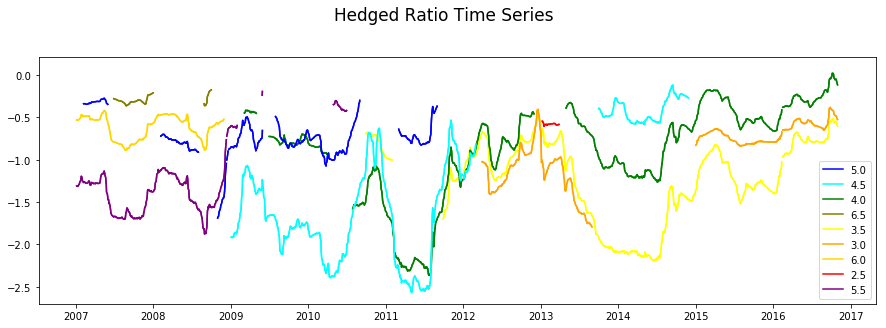

In [154]:
def getUniqLabel(handles, labels):
    uniq_label= {}
    for idx, lab in enumerate(labels):
        if lab not in uniq_label.keys():
            uniq_label[lab] = handles[idx]
    return uniq_label

color_code = {
    2.5: 'red',
    3.0: 'orange',
    3.5: 'yellow',
    4.0: 'green',
    4.5: 'cyan',
    5.0: 'blue',
    5.5: 'purple',
    6.0: 'gold',
    6.5: 'olive',
    7.0: 'brown',
    7.5: 'khaki',
    8.0: 'mediumslateblue',
    
}

fig = plt.figure(figsize = (15,10))
plt.suptitle('Hedged Ratio Time Series', y=0.95, fontsize=17)
ax = fig.add_subplot(211)
for c, hedge_list in result:
    ax.plot(hedge_list.index, hedge_list['hedge_Ratio'], c = color_code[c],label=c)
handles, labels = ax.get_legend_handles_labels()
uniq_label=getUniqLabel(handles, labels)
plt.legend(uniq_label.values(),uniq_label.keys())

### 4.2.2. Plot Hedging Performance

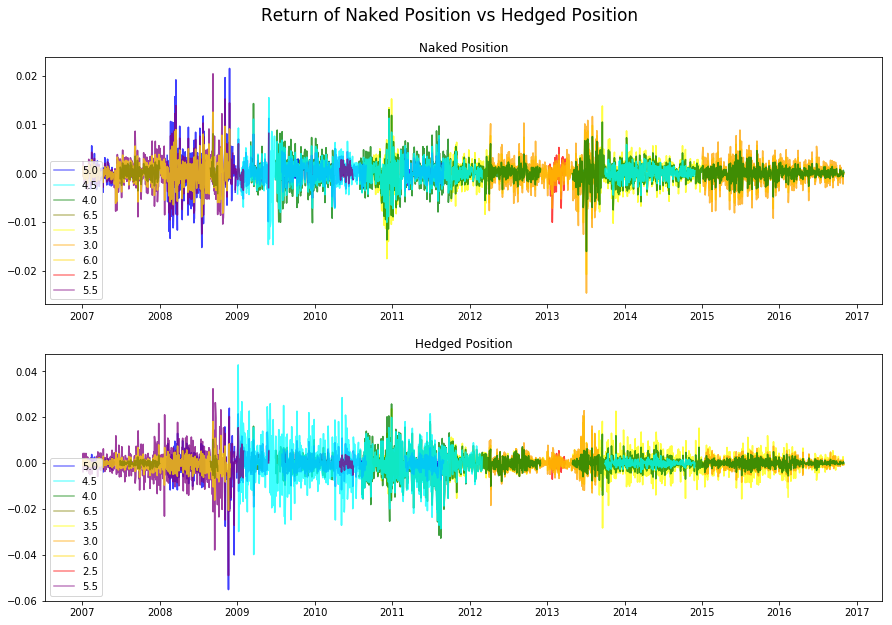

In [155]:
fig = plt.figure(figsize = (15,10))
plt.suptitle('Return of Naked Position vs Hedged Position', y=0.95, fontsize=17)
ax = fig.add_subplot(211)
for c, hedge_list in result:
    ax.plot(hedge_list.index, hedge_list['naked_return'], alpha=0.5,c = color_code[c],label=c)
handles, labels = ax.get_legend_handles_labels()
uniq_label=getUniqLabel(handles, labels)
plt.legend(uniq_label.values(),uniq_label.keys()) 
plt.title('Naked Position')

ax = fig.add_subplot(212)
for c, hedge_list in result:
    ax.plot(hedge_list.index, hedge_list['hedged_return'], alpha=0.5,c = color_code[c],label=c)
handles, labels = ax.get_legend_handles_labels()
uniq_label=getUniqLabel(handles, labels)
plt.legend(uniq_label.values(),uniq_label.keys()) 
plt.title('Hedged Position')